# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Neural-net-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [2]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from math import ceil
from pathlib import Path
from GEORGE_Library import *
%matplotlib inline

print("Done")

Done


## Define global variables

In [3]:
label_id_offset = 1
score_threshold = 0.0
category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'pollen'}, 3: {'id': 3, 'name': 'varroa'}, 4: {'id': 4, 'name': 'wasps'}}
val_augmented_fp = "Dataset/Custom_Dataset/Validation"
model_directory = 'C:/Users/khard/OneDrive/Documents/GitHub/GEORGE/'
model_name = 'extract_superimp_model'
model_dest = os.path.join(os.sep, model_directory, model_name)

print("Done")

Done


# Load test images and run inference with new model!

  0%|▏                                                                | 9/2500 [00:07<35:02,  1.18image/s, Subplot=9/9]


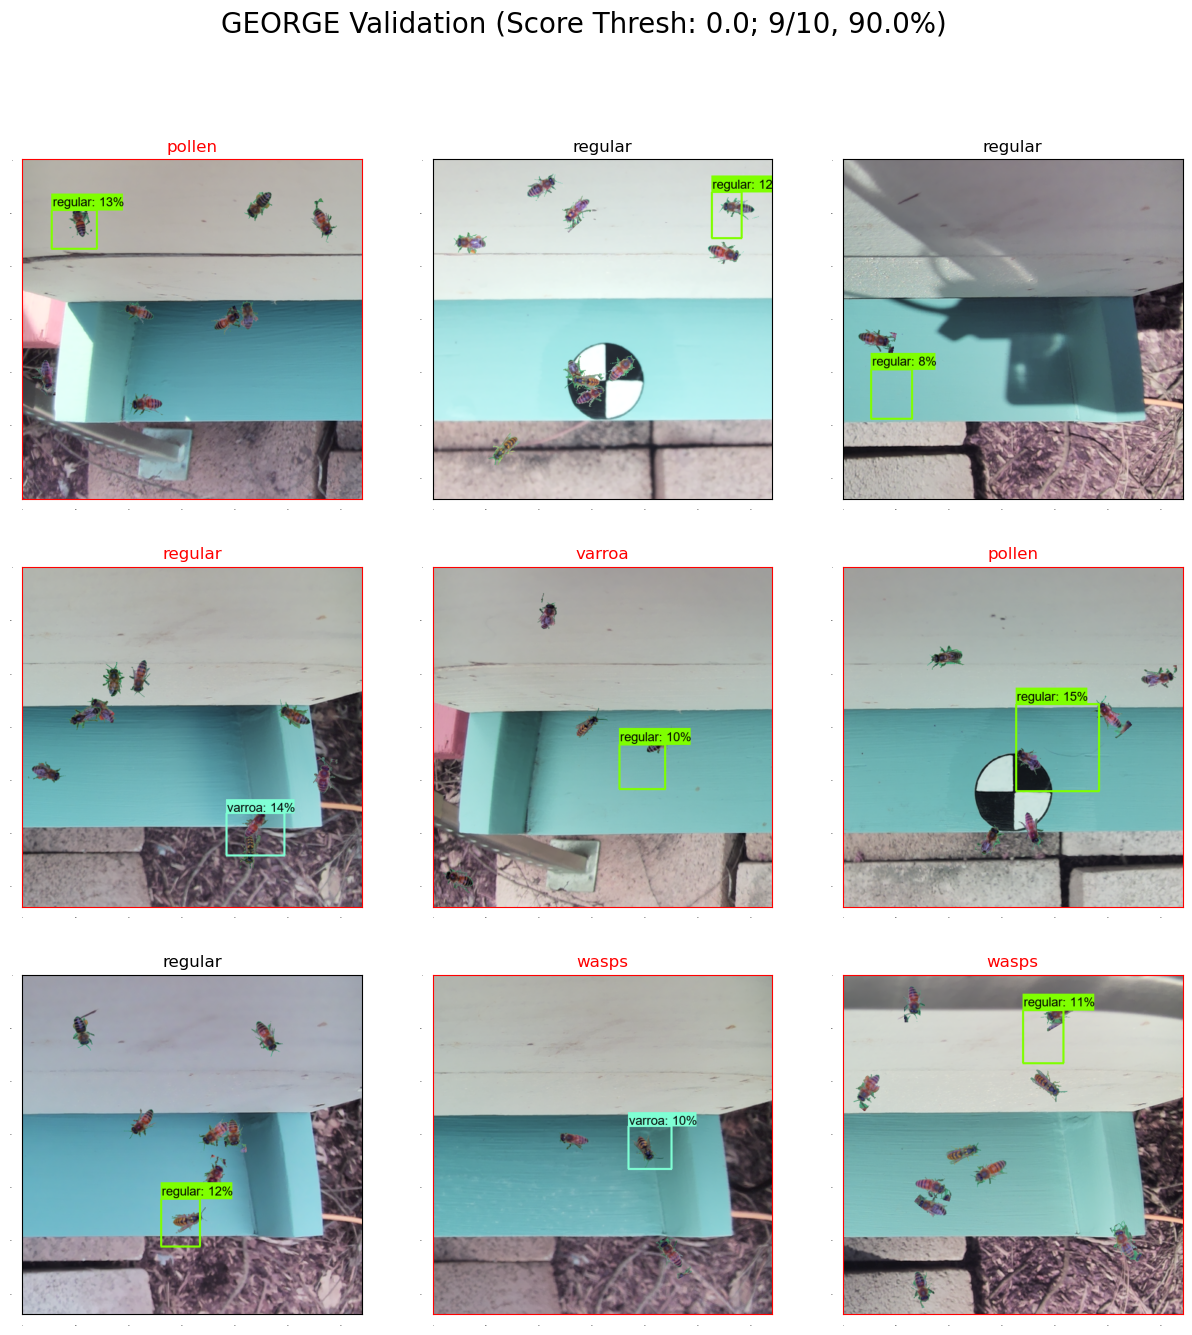

In [4]:
new_model = tf.saved_model.load(model_dest)
file_list = glob.glob(val_augmented_fp + '/*')
p = np.random.permutation(len(file_list))
val_random_file_list = [file_list[i] for i in p]

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [15, 15]

num_images = 9
save_plot = True

i = 0
j = 0

coco_annotations_file="custom_bee_dataset.json"
coco_images_dir=os.getcwd() + "\\" + val_augmented_fp
coco= COCOParser(coco_annotations_file, coco_images_dir)

with tqdm(total = (len(val_random_file_list)), unit="image") as pbar:
    while i < num_images and j < len(val_random_file_list):
        img_id = int(Path(val_random_file_list[j]).stem)
#-----------------------------------------------------------------------
        image = np.array(Image.open(val_random_file_list[j]).convert('RGB')).astype('uint8')

        # Start from Dataset_Builder
        ann_ids = coco.get_annIds(img_id)
        img_w, img_h = coco.get_wh(img_id)
        annotations = coco.load_anns(ann_ids)
        for ann in annotations:
            _bbox = ann['bbox']
            x, y, w, h = [int(b) for b in _bbox]
            class_id = ann["category_id"]
            class_name = coco.load_cats(class_id)[0]["name"]

            # Below is from the get_label function
            trans_label = class_id - 1
        label = (list(category_index.values())[trans_label], tf.one_hot(trans_label, 4), [trans_label + 1])
#---------------------------------------------------------------------------
        ax = plt.subplot(int(ceil(num_images)/3), 3, i + 1)
        
        input_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        input_tensor = tf.expand_dims(input_tensor, 0)
        detections = new_model.signatures['detect'](input_tensor)
        if (detections['detection_scores'][0][0].numpy()) > score_threshold:
            plot_detections(
            image,
            np.array([detections['detection_boxes'][0][0]]),
            [(detections['detection_classes'][0][0].numpy().astype(np.uint32) + label_id_offset)],
            [(detections['detection_scores'][0][0].numpy())],
            category_index)#, figsize=(30, 15))
 
            det_class = ""
            if int(detections['detection_classes'][0][0]) == 0:
                det_class = "regular"
            if int(detections['detection_classes'][0][0]) == 1:
                det_class = "pollen"
            if int(detections['detection_classes'][0][0]) == 2:
                det_class = "varroa"
            if int(detections['detection_classes'][0][0]) == 3:
                det_class = "wasps"
            
            if det_class != str(label[0]['name']):
                color = 'red'
                ax.set_title(label[0]['name'], fontsize=12, color=color)
                plt.setp(ax.spines.values(), color=color)
                plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
            else:
                ax.set_title(label[0]['name'], fontsize=12)
            i = i + 1
            j = j + 1
        else:
            j = j + 1
        pbar.set_postfix(Subplot=("%i" % i + "/%i" % num_images))
        pbar.update(1)
                  
plt.suptitle('GEORGE Validation (Score Thresh: %s; %s/%s, %s%%)' % (score_threshold, num_images, j + 1, round((num_images/(j+1))*100,2)), fontsize=20)
if save_plot:
    plt.savefig('GEORGE_Validation_Plot.png')
plt.show()